# MODELING 

Preferred clustering algorithms to be tested:
- KMeans Clustering
- Agglomerative Clustering
- DBSCAN

## 1 Modeling Prerequisites

### 1.1 Import Libraries

In [1]:
# !pip install hyperopt
# !pip install squarify
# !pip install joblib


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import calendar as cal
import logging
import matplotlib.pyplot as plt
import seaborn as sns 
import calendar as cal
import time
import os
import joblib

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

from matplotlib import colormaps
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.pipeline import Pipeline
from hyperopt import hp, tpe, rand, space_eval, fmin, Trials, STATUS_OK

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Define standard logging configuration
logging.basicConfig(
    level=logging.INFO,
    filename='../logs/onlineretail.log')

### 1.2 Load Files

In [2]:
try:
    df = pd.read_csv('../data/processed/online_retail_unscaled.csv')
    df_scaled = pd.read_csv('../data/processed/online_retail_scaled.csv')
    df_m_outliers = pd.read_csv('../data/processed/online_retail_m_outliers.csv')
    df_f_outliers = pd.read_csv('../data/processed/online_retail_f_outliers.csv')
    
except OSError as e:
    logging.error(e)

### 1.3 Random Seed

In [4]:
random_seed = 100

np.random.seed(random_seed)
np.random.default_rng(random_seed)
np.random.RandomState(random_seed)

RandomState(MT19937) at 0x7F579D9F7040

## 2 Hyperparameter Tuning

DBSCAN Pre-requisites:

To determine the parameters for DBSCAN, it's essential to determine the two hyperparameters in DBSCAN (MinPts and 𝜀𝜀 ) that need to be optimized to yield good clustering results.\
Finding a good combination of MinPts and 𝜀𝜀 can be problematic if the density differences in the dataset are relatively large. \
A general rule of thumb is to set MinPts >= D+1, where D is the number of dimensions in the dataset. For most cases, a minimum value of MinPts = 3 is recommended.\
Create a k-distance graph to serve as a guide in selecting the appropriate epsilon value.\
Steps:
1. Calculate the distance to the k-th nearest neighbor for each point.
2. Sort and plot the distance and use the elbow method to choose the epsilon. 

Specific to the hyperparameter optimization, a range of values near the elbow point in the K-distance graph will be used.

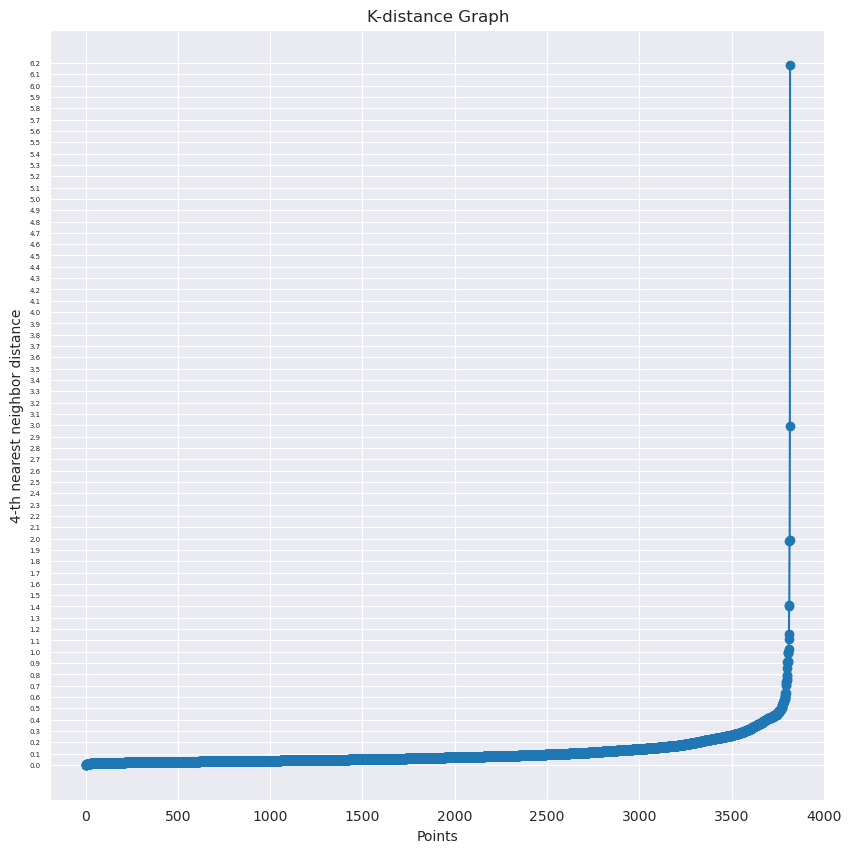

In [5]:
test_k = 4
X_scaled = df_scaled.to_numpy()

# Use NN to determine distances
mdl_nn = NearestNeighbors(n_neighbors=test_k)
mdl_nn.fit(X_scaled)

distances, indices = mdl_nn.kneighbors(X_scaled)
distances = np.sort(distances[:, test_k-1])

# Plot and choose the elbow point
sns.set_style('darkgrid')
plt.figure(figsize=(10,10))
plt.plot(distances, '-o')

plt.xlabel('Points')
plt.ylabel(f'{test_k}-th nearest neighbor distance')
plt.yticks(np.arange(0, max(distances)+0.1, 0.1), fontsize=5)
plt.title('K-distance Graph')
plt.show()

<div class="alert alert-block alert-success">
The estimated elbow point on the K-distance graph is between <b>0.1 - 0.2</b>. This range will be used for the DBSCAN hyperparameter tuning.</div>

In [3]:
X = df.to_numpy()
X_scaled = df_scaled.to_numpy()

print(X.shape,'::', X_scaled.shape)

(3817, 3) :: (3817, 3)


### 2.1 Define model parameters and spaces

In [7]:
#Dictionary for model paramaters:

models = {
    'KMeans': {
        'model': KMeans(random_state=random_seed),
        'params': {
            'cluster__n_clusters': np.arange(2,11,1),
            'cluster__init' : ['random', 'k-means++'],
            'cluster__n_init' :  np.arange(5,11,5),
            'cluster__max_iter': np.arange(100,1100,100),
            'cluster__tol': [0.0001, 0.001, 0.01, 0.1],
            'cluster__algorithm' : ['lloyd', 'elkan']
        }
    },

    'Agglomerative': {
        'model': AgglomerativeClustering(),
        'params': {
            'cluster__n_clusters': np.arange(2,11,1),
            'cluster__metric' : [ 'euclidean', 'l1', 'l2', 'manhattan', 'cosine'], 
            'cluster__linkage': ['complete', 'average', 'single'],
            'cluster__compute_distances' : [True, False]
        }
    },

    'DBSCAN': {
        'model': DBSCAN(), 
        'params': {
            'cluster__eps': np.arange(0.1, 0.2, 0.01),
            'cluster__min_samples' : np.arange(4,11,1), 
            'cluster__metric': ['euclidean']
        }
    }
}

In [8]:
#Spaces for KMeans required for SMBO using hyperopt

km_space = {
    'n_clusters': hp.uniformint('n_clusters', 2, 10, q=2),
    'init' : hp.choice('init', ['random', 'k-means++']),
    'n_init' :hp.uniformint('n_init', 5,10, q=5),
    'max_iter': hp.uniformint('max_iter', 100, 1000, q=100),
    'tol': hp.choice('tol', [0.0001, 0.001, 0.01, 0.1]),
    'algorithm' : hp.choice('algorithm', ['lloyd', 'elkan'])
}

### 2.2 Functions for Cross-Validation

**Functions for Grid/Randomized Search**

In [9]:
# Custom function for Randomized Search and Grid Search:

def f_hp_optimization(desiredcv, x_data, pipe, params, njobs, f_scoring, fold):
    '''Custom function that runs GridSearchCV and RandomSearch CV using the estimator and parameter of choice.
    
    Input: 
        desiredcv - CrossValidation model (sklearn.model_selection object, i.e. RandomizedSearchCV | GridSearchCV)
        x_data - working dataset (numpy.ndarray)
        pipe - defined pipeline( Pipeline object )
        params - a dictionary of the model's parameters (dict)
        n_jobs - no of jobs (int)
        f_scoring - scoring metric or a custom function for clustering algorithms  (func)
        fold - cross-validation number of folds (int)
    Return:
        Cross-validation object fitted with data (sklearn.model_selection._search.*Randomized\Grid* SearchCV object)
    '''

    cv = None
    time_start = time.time()

    
    if desiredcv == GridSearchCV:

        try:
            cv = GridSearchCV(pipe, param_grid=params, n_jobs = njobs, scoring=f_scoring, cv=fold)  
        except Exception as e:
            logging.error(e)

    elif desiredcv == RandomizedSearchCV:

        try:
            cv = RandomizedSearchCV(pipe,param_distributions = params, n_jobs = njobs,  scoring=f_scoring, cv=fold, random_state=random_seed )  
        except Exception as e:
            logging.error(e)
            
    if cv!= None:
        cv.fit(x_data)
        
        time_end = time.time()
        runtime = time_end - time_start
        
        print(f'+++ {pipe['cluster']} {desiredcv} results: +++')
        print('Model Total running time: ', runtime)
        print("Best hyperparameters: ", cv.best_params_)
        print('Silhouette Score: ', cv.best_score_)
        print('\n')

    return cv

In [10]:
# Custom scoring functions for GridSearchCV and RandomizedSearchCV

def f_silhouette_score(pipex, X):
    silscore = silhouette_score(X, pipex.fit_predict(X))
    return silscore

def f_inertia_score(pipex, X):
    return pipex['cluster'].inertia_

**Functions for Bayesian Search**

In [11]:
# Objective functions for Bayesian Search using SMBO technique in ***hyperopt*** package for KMeans

def km_f_objective(space):
    
    kmeans = KMeans(n_clusters = space['n_clusters'], 
                    random_state = random_seed, 
                    tol= space['tol'], 
                    n_init= space['n_init'], 
                    max_iter= space['max_iter'], 
                    init= space['init'],
                    algorithm= space['algorithm']
                    )

    kmeans.fit(X_scaled)
    score = kmeans.inertia_
     
    return {'loss' : -(score), 'status': STATUS_OK }

***Scoring functions for Agglomerative Clustering and DBSCAN:***

Both Agglomerative clustering and DBSCAN have no explicit loss function. Agglomerative Clustering use distance metric, and DBSCAN does not necessarily divide data into spherical clusters, so inertia is not a good metric for evaluating DBSCAN and Agglomerative Clustering models.\
In the next section, Silhouette scores will be computed for both algorithms in CV. SMBO will be skipped for both due to the lack of loss function on both algorithms

Hyperopt documentation: https://github.com/hyperopt/hyperopt/wiki/FMin

### 2.3 Nested Cross Validation

This step will utilize nested cross-validation approach to determine the optimal parameters per clustering algorithm. In summary, this step will: 
1. Cycle through the 3 chosen cluster algorithms, namely: KMeans, Agglomerative Hierarchichal, and DBSCAN. 
2. For each algorithm, perform hyperparameter tuning.
>- KMeans - GridSearchCV, RandomizedSearchCV, and SMBO
>- Agglomerative Hierarchichal - GridSearchCV, RandomizedSearchCV
>- DBSCAN - GridSearchCV, RandomizedSearchCV

3. Apply custom scoring functions for the ffg algorithms: 
>- KMeans -  Silhouette score via custom scoring function in CVs.No scoring from SMBO as silhouette score is not a loss function.   
>- Agglomerative Hierarchichal - Silhouette score via custom scoring function in CVs. No loss function and inertia is not applicable so SMBO is skipped.
>- DBSCAN - Silhouette score via custom scoring function in CVs. No loss function and inertia is not applicable so SMBO is skipped.

In [12]:
#Core Nested Cross-Validation process

hps_results = []

for model_name, model_info in models.items():
    
    # Define pipeline steps
    pipeline = Pipeline(steps=[
                    ( 'scaler', [ MinMaxScaler() if model_info['model'] == DBSCAN else StandardScaler()][0] ),
                    ( 'cluster', model_info['model'] )])

    # Run Randomized Search CV using f_hp_optimization
    rscv = f_hp_optimization(desiredcv = RandomizedSearchCV, x_data=X, pipe=pipeline, params = model_info['params'], njobs= -1, f_scoring=f_silhouette_score, fold=10)
    
    # Append Randomized Search CV results
    if rscv:
        hps_results.append(
            {
                'Model' : model_name,
                'Tuning' : 'RandomizedSearchCV',
                'Best_params' : rscv.best_params_,
                'Silhouette_Score' : rscv.best_score_        
            })

    # Run Grid Search CV using f_hp_optimization
    gscv = f_hp_optimization(desiredcv = GridSearchCV, x_data=X, pipe=pipeline, params = model_info['params'], njobs= -1, f_scoring=f_silhouette_score, fold=10)
   
    # Append Grid Search CV results
    if gscv:
        hps_results.append(
            {
                'Model' : model_name,
                'Tuning' : 'GridSeachCV',
                'Best_params' : gscv.best_params_,
                'Silhouette_Score' : gscv.best_score_        
            })
   
    match model_name:

        case 'KMeans':
            print('----- SMBO: KMeans Clustering: -----')
            model_fmin = km_f_objective
            model_space = km_space

        case 'Agglomerative':
            continue

        case 'DBSCAN':
            continue

        case _:        
            continue

    # Perform SMBO. Note: X has to be scaled inside the function

    time_start = time.time()
    smbo_best=None

    trials = Trials()   

    try: 
        smbo_best = fmin( fn = model_fmin, 
                            space = model_space,
                            algo  = tpe.suggest,
                            max_evals = 100, 
                            trials = trials,
                            rstate = np.random.default_rng(random_seed))    
        logging.info(f'[Nested CV Step Success] {model_name} SMBO Best Parameters: {smbo_best}')
    
    except Exception as e:
        logging.error(f'[Nested CV Step ERROR]: {e}')

    time_end = time.time()
    runtime = time_end - time_start
    print('Model Total running time: ', runtime)
    
    # Append SMBO results
    if smbo_best:
        losses = trials.losses()
        hps_results.append(
            {
            'Model' : model_name,
            'Tuning' : 'SMBO',
            'Best_params' : smbo_best,
            'Silhouette_Score' : np.nan
            })

        print(f'SMBO {model_name} best parameters: ', smbo_best)

    print('\n')

+++ KMeans(random_state=100) <class 'sklearn.model_selection._search.RandomizedSearchCV'> results: +++
Model Total running time:  3.0065176486968994
Best hyperparameters:  {'cluster__tol': 0.1, 'cluster__n_init': 10, 'cluster__n_clusters': 2, 'cluster__max_iter': 200, 'cluster__init': 'random', 'cluster__algorithm': 'lloyd'}
Silhouette Score:  0.5984635762963102


+++ KMeans(random_state=100) <class 'sklearn.model_selection._search.GridSearchCV'> results: +++
Model Total running time:  202.80599856376648
Best hyperparameters:  {'cluster__algorithm': 'lloyd', 'cluster__init': 'k-means++', 'cluster__max_iter': 100, 'cluster__n_clusters': 2, 'cluster__n_init': 5, 'cluster__tol': 0.1}
Silhouette Score:  0.602058462575161


----- SMBO: KMeans Clustering: -----
100%|██████████| 100/100 [00:02<00:00, 41.73trial/s, best loss: -6505.689679929349]
Model Total running time:  2.418832302093506
SMBO KMeans best parameters:  {'algorithm': 1, 'init': 0, 'max_iter': 991.0, 'n_clusters': 2.0, 'n_init':

/home/edu/anaconda3/envs/ds-retail-env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/edu/anaconda3/envs/ds-retail-env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_73705/929279214.py", line 4, in f_silhouette_score
  File "/home/edu/anaconda3/envs/ds-retail-env/lib/python3.12/site-packages/sklearn/utils/_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/edu/anaconda3/envs/ds-retail-env/lib/python3.12/site-packages/sklearn/metrics/cluster/_unsupervised.py", line 139, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, 

+++ DBSCAN() <class 'sklearn.model_selection._search.GridSearchCV'> results: +++
Model Total running time:  2.530931234359741
Best hyperparameters:  {'cluster__eps': 0.16999999999999998, 'cluster__metric': 'euclidean', 'cluster__min_samples': 10}
Silhouette Score:  -0.15949935617142658




**Model Selection based on Model Evaluation Metrics**

In [13]:
# Tabulate Hyperparameter Search results
df_hps = pd.DataFrame(hps_results)
df_hps.sort_values(by='Silhouette_Score', ascending=False, inplace=True)
df_hps.fillna('Score N/A',inplace=True)

# Display results
df_hps

,Model,Tuning,Best_params,Silhouette_Score
1,KMeans,GridSeachCV,"{'cluster__algorithm': 'lloyd', 'cluster__init...",0.602058
0,KMeans,RandomizedSearchCV,"{'cluster__tol': 0.1, 'cluster__n_init': 10, '...",0.598464
4,Agglomerative,GridSeachCV,"{'cluster__compute_distances': True, 'cluster_...",0.489265
3,Agglomerative,RandomizedSearchCV,"{'cluster__n_clusters': 2, 'cluster__metric': ...",0.35807
5,DBSCAN,RandomizedSearchCV,"{'cluster__min_samples': 10, 'cluster__metric'...",-0.159499
6,DBSCAN,GridSeachCV,"{'cluster__eps': 0.16999999999999998, 'cluster...",-0.159499
2,KMeans,SMBO,"{'algorithm': 1, 'init': 0, 'max_iter': 991.0,...",Score N/A


<div class="alert alert-block alert-success">
Out of the model evaluation outcomes, KMeans and Agglomerative Hierarchichal clustering yielded more promising silhouette scores. It can also be surmised that DBSCAN may not be the appropriate clustering algorithm for this dataset since it has negative results which indicates that the clusters overlap more compared to other algorithms that have higher silhouette score. 
</div>

In [14]:
# Save hyperparameter tuning results to .csv file
hps_fname = 'hp_tuning.csv'
hps_path = '../models/hp_tuning_results/'
hps_file = os.path.join(hps_path, hps_fname) 
df_hps.to_csv(hps_file, index=False)

**Compare KMeans inertia scores using GridSearch, RandomizedSearch, and SMBO**

In [15]:
#Re-execute hyperparameter search on KMeans algorithm. This time, using inertia in the score function

results = []

pipeline = Pipeline(steps=[
                    ( 'scaler', StandardScaler() ),
                    ( 'cluster', KMeans(random_state=random_seed ) ) ])

rscv = f_hp_optimization(desiredcv = RandomizedSearchCV, x_data=X, pipe=pipeline, params = models['KMeans']['params'], njobs= -1, f_scoring=f_inertia_score, fold=10)
    
# Append Randomized Search CV results
if rscv:
    results.append(
        {   'Model' : 'KMeans',
            'Tuning' : 'RandomizedSearchCV',
            'Best_params' : rscv.best_params_,
            'Inertia' : rscv.best_score_ })

gscv = f_hp_optimization(desiredcv = GridSearchCV, x_data=X, pipe=pipeline, params = models['KMeans']['params'], njobs= -1, f_scoring=f_inertia_score, fold=10)
    
# Append Grid Search CV results
if gscv:
    results.append(
        {   'Model' : 'KMeans',
            'Tuning' : 'GridSearchCV',
            'Best_params' : gscv.best_params_,
            'Inertia' : gscv.best_score_ })

# Perform SMBO. Note: X has to be scaled
trials = Trials()    

time_start = time.time()
km_smbo = None

try:
    km_smbo = fmin( fn = km_f_objective, 
                            space =  km_space,
                            algo  = tpe.suggest,
                            max_evals = 100, 
                            trials = trials,
                            rstate = np.random.default_rng(random_seed)    )
    logging.info(f'[KM Parameter Optimization Success]: {km_smbo}')

except Exception as e:
    
    logging.error(f'[KM Parameter Optimization Error]: {e}')

time_end = time.time()
runtime = time_end - time_start
print('Model Total running time: ', runtime)

if km_smbo:
    losses = trials.losses()

    # Append Randomized Search CV results
    results.append(
            {   'Model' : 'KMeans',
                'Tuning' : 'SMBO',
                'Best_params' : km_smbo,
                'Inertia' : abs(min(losses))})

    print(f'SMBO {model_name} best parameters: ', km_smbo)
print('\n')

+++ KMeans(random_state=100) <class 'sklearn.model_selection._search.RandomizedSearchCV'> results: +++
Model Total running time:  0.7236037254333496
Best hyperparameters:  {'cluster__tol': 0.1, 'cluster__n_init': 10, 'cluster__n_clusters': 2, 'cluster__max_iter': 200, 'cluster__init': 'random', 'cluster__algorithm': 'lloyd'}
Silhouette Score:  5780.09743041892


+++ KMeans(random_state=100) <class 'sklearn.model_selection._search.GridSearchCV'> results: +++
Model Total running time:  142.72453927993774
Best hyperparameters:  {'cluster__algorithm': 'lloyd', 'cluster__init': 'k-means++', 'cluster__max_iter': 100, 'cluster__n_clusters': 2, 'cluster__n_init': 5, 'cluster__tol': 0.1}
Silhouette Score:  5798.164356724086


100%|██████████| 100/100 [00:01<00:00, 67.75trial/s, best loss: -6419.7229907037645]
Model Total running time:  1.4904282093048096
SMBO DBSCAN best parameters:  {'algorithm': 0, 'init': 1, 'max_iter': 197.0, 'n_clusters': 2.0, 'n_init': 9.0, 'tol': 2}




In [16]:
df_inertia = pd.DataFrame(results)
df_inertia.sort_values('Inertia', ascending=False, inplace=True)
df_inertia

,Model,Tuning,Best_params,Inertia
2,KMeans,SMBO,"{'algorithm': 0, 'init': 1, 'max_iter': 197.0,...",6419.722991
1,KMeans,GridSearchCV,"{'cluster__algorithm': 'lloyd', 'cluster__init...",5798.164357
0,KMeans,RandomizedSearchCV,"{'cluster__tol': 0.1, 'cluster__n_init': 10, '...",5780.097430


In [17]:
# Save results to csv file
eval_fname = 'hp_tuning_kmeans.csv'
eval_path = '../models/hp_tuning_results/'
eval_file = os.path.join(eval_path, eval_fname)
df_inertia.to_csv(eval_file, index=False)

**Optimal Hyperparameter selection**

GridSearch and Random search methods are relatively inefficient compared to SMBO.\
SMBO works by considering the previously seen hyperparameter combinations when choosing the next set of hyperparameters to evluate. Grid and random searches, on the other hand, are completely uninformed by past evaluations and spends significant amount of time evaluating “bad” hyperparameters.

In [18]:
# Manually choose SMBO parameters

best_inertia = df_inertia[df_inertia.Tuning == 'SMBO']

model = best_inertia['Model'].item()
tuning = best_inertia['Tuning'].item()
params = best_inertia['Best_params'].item()

final_best_params= space_eval(km_space, km_smbo)

print('Chosen algorithm :', model)
print('Best parameters :', final_best_params )

Chosen algorithm : KMeans
Best parameters : {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 197, 'n_clusters': 2, 'n_init': 9, 'tol': 0.01}


## 3 Modeling

**KMeans Modeling**

In [19]:
k_clusters = range(2,11)
cluster_labels = {}
centroids = {}
inertias = {}

for k in k_clusters:
    pipeline = Pipeline(steps=[
                        ( 'scaler', StandardScaler() ),
                        ( 'kmeans', KMeans() )])
    
    pipeline.set_params(kmeans__tol = final_best_params['tol'], 
                        kmeans__n_init = final_best_params['n_init'], 
                        kmeans__n_clusters = k, 
                        kmeans__max_iter = final_best_params['max_iter'],  
                        kmeans__init = final_best_params['init'], 
                        kmeans__algorithm = final_best_params['algorithm'],
                        kmeans__random_state = random_seed)
    
    
    pipe_km_fit = pipeline.fit(X)

    pkl_fname = "final_km_k_{}.pkl".format(k)
    pkl_path = '../models/'
    pkl_file = os.path.join( pkl_path, pkl_fname)

    joblib.dump(pipe_km_fit, pkl_file)
    
    cluster_label = pipeline.predict(X)

    #Save labels, centroids, and inertias
    cluster_labels[k] = cluster_label
    centroids[k] = pipeline['kmeans'].cluster_centers_

    inertias[k] = pipeline['kmeans'].inertia_

# Display inertias and save for metrics csv report later
eval_inertia = {}

for k in k_clusters:
    eval_inertia[k] = inertias[k]  
    print(f'n_clusters = {k} : {inertias[k]}')

n_clusters = 2 : 6419.7229907037645
n_clusters = 3 : 3780.6661652982475
n_clusters = 4 : 2928.9053906695144
n_clusters = 5 : 2458.844538240025
n_clusters = 6 : 2136.5175518574597
n_clusters = 7 : 1904.22370628638
n_clusters = 8 : 1694.6314117806558
n_clusters = 9 : 1549.9272164699148
n_clusters = 10 : 1454.3757894528867


In [ ]:
# Testing the imported pkl files. Should have the same results as above.

k_clusters = range(2,11)
pkl_path = '../models/'
inertias = {}

for k in k_clusters:
    ipkl_name = "final_km_k_{}.pkl".format(k)
    ipkl_file = os.path.join(pkl_path, ipkl_name)
    imodel = joblib.load(ipkl_file)
    imodel.fit(X)
    inertias[k] = imodel['kmeans'].inertia_

inertias

{2: 6419.7229907037645,
 3: 3780.6661652982475,
 4: 2928.9053906695144,
 5: 2458.844538240025,
 6: 2136.5175518574597,
 7: 1904.22370628638,
 8: 1694.6314117806555,
 9: 1549.9272164699148,
 10: 1454.3757894528867}

Pickle file test generated the same result as the previous test.

***Determining the optimal k number of clusters***

There is no direct way to determine the optimal # of Ks from the training loss itself; loss continue to decrease for larger numbers of centers (as any given point's distance to the centers becomes lesser as they are closer). 

An Inertia Plot is useful for plotting the loss (inertia) versus the number of clusters.

**Inertia Plot: Selecting the best K- clusters**

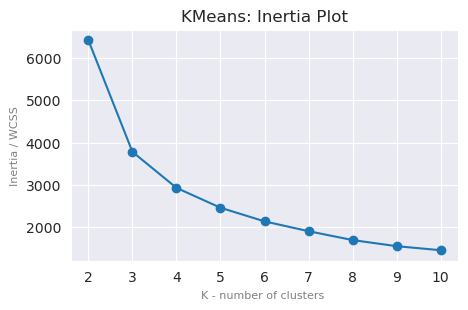

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(k_clusters, inertias.values(), '-o')
plt.xlabel('K - number of clusters ', fontsize=8, color='gray')
plt.ylabel('Inertia / WCSS', fontsize=8, color='gray')
plt.title('KMeans: Inertia Plot')
plt.show()

<div class="alert alert-block alert-success">
Based on the Inertia plot, the knee point is most likely at n_clusters = 3 or 4.
</div>

To further help in deciding the optimal n_clusters, the following silhouette analysis will focus on n_clusters = 2 to 5. 

**Silhouette Analysis**

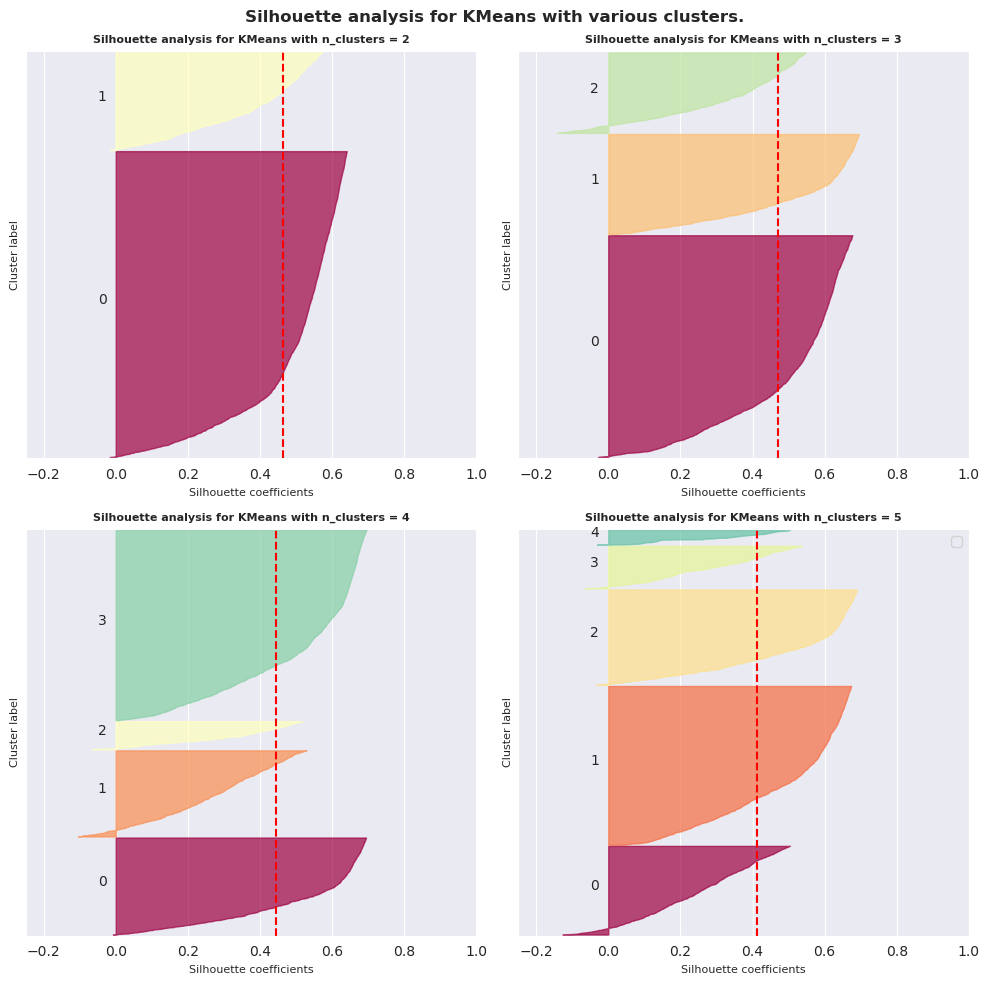

In [21]:
fig, ax1 = plt.subplots(2,2, figsize=(10,10))
avg_silhouette_scores = []
avg_per_k = {}

for i, k in enumerate(k_clusters[0:4]):

    xctr = yctr = 0
    if i%2 != 0:
        yctr = 1
    if i>=2:
        xctr = 1
    
    # The silhouette coefficient can range from -1, 1 
    ax1[xctr][yctr].set_xlim([-0.25, 1])
    ax1[xctr][yctr].set_ylim([-1, len(X_scaled) + (k + 1) * 10])

    clusterer = KMeans(n_clusters=k, 
                       random_state=random_seed, 
                       n_init = final_best_params['n_init'],
                       max_iter=final_best_params['max_iter'], 
                       init = final_best_params['init'],
                       tol = final_best_params['tol'],
                       algorithm = final_best_params['algorithm'])
    
    cl_labels = clusterer.fit_predict(X_scaled)

    silhouette_avg  = silhouette_score(X_scaled, cl_labels)
    avg_silhouette_scores.append(silhouette_avg)
    avg_per_k[k] = silhouette_avg
    
    sample_silhouette_values = silhouette_samples(X_scaled, cl_labels)

    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cl_labels == i]

        ith_cluster_silhouette_values.sort()
    
        size_cluster_i = ith_cluster_silhouette_values.shape[0] 
        y_upper = y_lower + size_cluster_i

        cmap = colormaps.get_cmap('Spectral')
        color = cmap(float(i) / k)
        ax1[xctr][yctr].fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1[xctr][yctr].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples

   
    ax1[xctr][yctr].set_title("Silhouette analysis for KMeans with n_clusters = %d" % k, fontsize=8, fontweight='bold')
    ax1[xctr][yctr].set_xlabel("Silhouette coefficients", fontsize=8)
    ax1[xctr][yctr].set_ylabel("Cluster label",  fontsize=8)


    ax1[xctr][yctr].axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1[xctr][yctr].set_yticks([])  # Clear the yaxis labels / ticks
    ax1[xctr][yctr].set_xticks([ -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.legend()
    plt.tight_layout()
    plt.suptitle("Silhouette analysis for KMeans with various clusters.",
                 fontsize=12, fontweight='bold')

plt.show()

<div class="alert alert-block alert-success">
Between n_clusters=3 and n_clusters=4, the former has lower negative silhouette coefficient values, and the cluster label heights is even better compared to the latter.

The optimal k number of clusters for this dataset using KMeans algorithm is 3. 
</div>

Recalculate the silhouette scores (k= 2 to 10) and combine them with the inertias retrieved earlier to the metrics .csv file

In [22]:
eval_silhouette = {}
for k in k_clusters: 
    clusterer = KMeans(n_clusters=k, 
            random_state=random_seed, 
            n_init = final_best_params['n_init'],
            max_iter=final_best_params['max_iter'], 
            init = final_best_params['init'],
            tol = final_best_params['tol'],
            algorithm = final_best_params['algorithm'])
    
    cl_labels = clusterer.fit_predict(X_scaled)
    silhouette_avg  = silhouette_score(X_scaled, cl_labels)
    eval_silhouette[k] = round(silhouette_avg,5)

# Inertia Results 
df_eval_inertia = pd.DataFrame(list(eval_inertia.items()) )\
    .rename(columns = {0:'K', 1:'Inertia'})

# Silhouette scores
df_eval_silhouette = pd.DataFrame(list(eval_silhouette.items()) )\
    .rename(columns = {0:'K', 1:'Silhouette'})

# Combine results
df_eval_metrics = df_eval_inertia.merge(df_eval_silhouette, on='K')

# Save to .csv file
df_eval_metrics.to_csv('../models/model_evaluation/km_metrics.csv')

# Display result
df_eval_metrics

,K,Inertia,Silhouette
0,2,6419.722991,0.46334
1,3,3780.666165,0.46928
2,4,2928.905391,0.44552
3,5,2458.844538,0.41169
4,6,2136.517552,0.37651
5,7,1904.223706,0.37946
6,8,1694.631412,0.35495
7,9,1549.927216,0.33854
8,10,1454.375789,0.33545


## 4 Cluster Analysis

### 4.1 Cluster Distribution

In [34]:
# Create a new column, Cluster

df_clustered = df.copy(deep=True)
df_clustered['Cluster'] = cluster_labels[3]
df_clustered['Cluster'].value_counts()

Cluster
0    2104
1     950
2     763
Name: count, dtype: int64

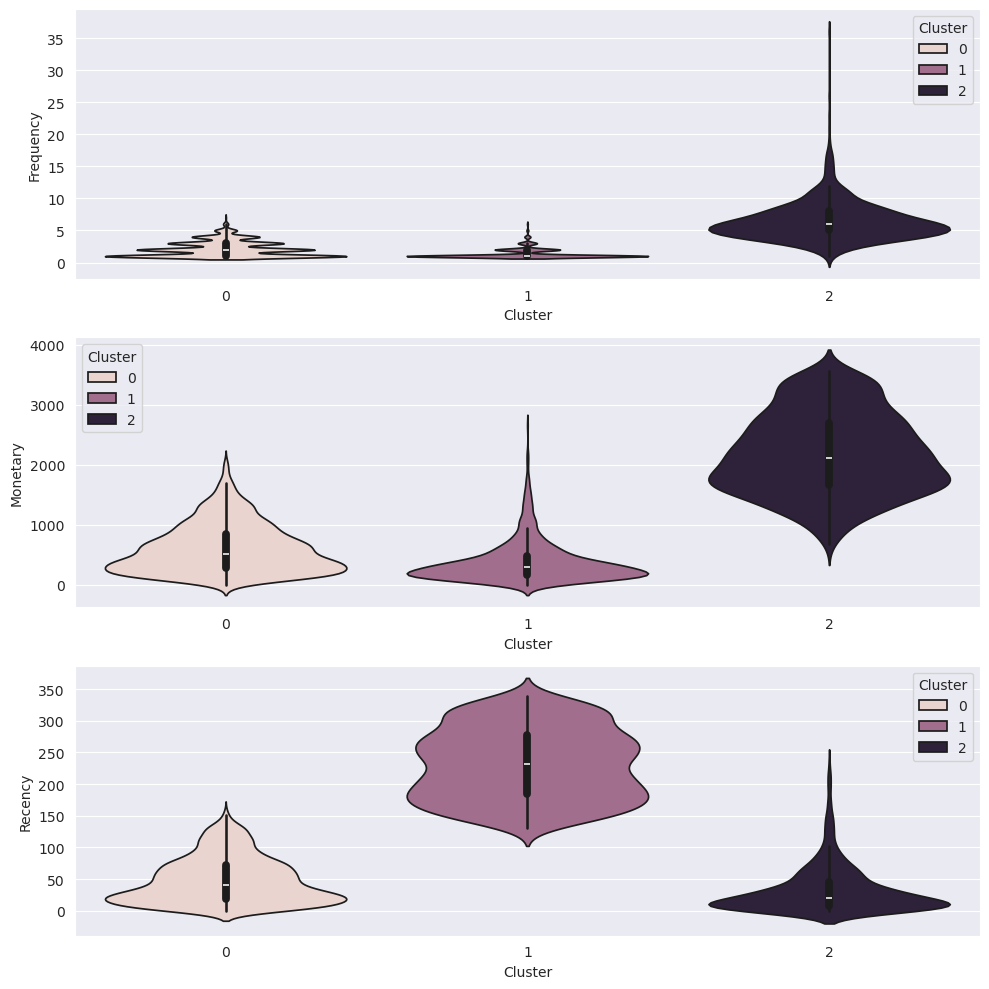

In [35]:
rfm_cols = df_clustered.columns.to_list()
rfm_cols.remove('Cluster')
rfm_cols

plt.figure(figsize=(10,10))

for idx, col in enumerate(rfm_cols):

    plt.subplot(3, 1, idx+1)
    sns.violinplot(x=df_clustered['Cluster'], y=df_clustered[col], hue=df_clustered['Cluster']) 

plt.tight_layout()

### 4.2 Cluster Assessment

Cluster 0: **Moderate**

- Moderately frequent buyers that are not necessarily high spenders, and haven't purchased recently. 

Cluster 1: **Recent**

- Less frequent buyers who are low-spenders but made recent purchases.

Cluster 2: **Loyal**

- Frequent shoppers who are high spenders, although no recent purchases.

### 4.3 Cluster Mapping

Map the assigned customer segment labels in the previous assessment section to the cluster numbers

In [36]:
cluster_mapping = {
    0: 'Moderate', 
    1: 'Recent',
    2: 'Loyal'
}

df_clustered['Cluster'] = df_clustered.Cluster.map(cluster_mapping)
df_clustered.Cluster.value_counts()

Cluster
Moderate    2104
Recent       950
Loyal        763
Name: count, dtype: int64

In [37]:
df_clustered.head()

,Frequency,Monetary,Recency,Cluster
0,3,904.44,75,Moderate
1,1,1757.55,18,Moderate
2,1,334.40,310,Recent
3,8,2506.04,36,Loyal
4,1,89.00,204,Recent


## 5 Outliers Analysis

**Assigning Labels to Outliers**

In [38]:
df_m_outliers.shape[0], df_f_outliers.shape[0]

(402, 412)

Outliers will be designated as follows:
>  - Monetary outliers : High-Spenders Customers
>  - Frequency outliers : Frequent Customers
>  - Both Monetary and Frequency outliers : VIPs 

In [39]:
df_vips = df_m_outliers.reset_index().merge(df_f_outliers, how='inner').set_index('index')
df_high_spenders = df_m_outliers.drop(df_vips.index)
df_frequent = df_f_outliers.drop(df_vips.index)

df_vips.drop('LastPurchaseDate', axis=1, inplace=True)
df_vips.set_index('CustomerID', inplace=True)
df_vips['Cluster'] = 'VIPs'

df_high_spenders.drop('LastPurchaseDate', axis=1, inplace=True)
df_high_spenders.set_index('CustomerID', inplace=True)
df_high_spenders['Cluster'] = 'High Spenders'

df_frequent.drop('LastPurchaseDate', axis=1, inplace=True)
df_frequent.set_index('CustomerID', inplace=True)
df_frequent['Cluster'] = 'Frequent'

**Combining different data**

In [40]:
df_all = pd.concat([df_clustered, df_vips, df_high_spenders, df_frequent])
df_all.head()

,Frequency,Monetary,Recency,Cluster
0,3,904.44,75,Moderate
1,1,1757.55,18,Moderate
2,1,334.40,310,Recent
3,8,2506.04,36,Loyal
4,1,89.00,204,Recent


## 6 Customer Segmentation Visualization

In [41]:
df_groupings = pd.DataFrame(df_all.Cluster.value_counts())
df_groupings.reset_index(inplace=True)

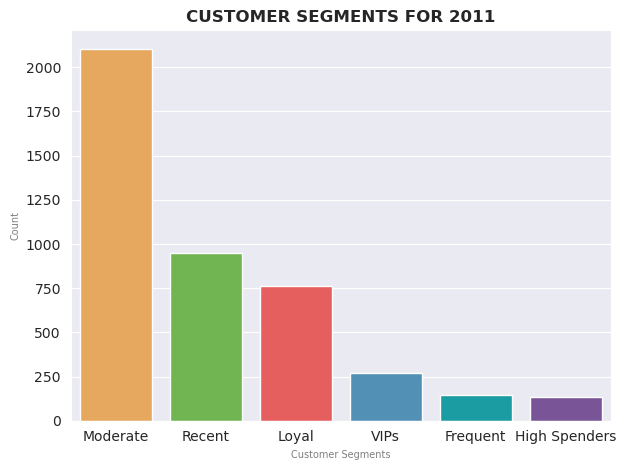

In [ ]:
palette = {
                'Recent' : '#69c641',    
                'Moderate': '#fda848',   
                'Loyal':  '#fd4848' ,  
                'VIPs':   '#4196c6',
                'Frequent': '#a0e7d7',      
                'High Spenders': '#7a4aa2'       
}

sns.set_style('darkgrid')
plt.figure(figsize=(10,10))
sns.barplot( data=df_groupings, x='Cluster', y='count', palette = palette)
plt.xlabel('Customer Segments', fontsize=7, color='gray')
plt.ylabel('Count', fontsize=7, color='gray')
plt.title('CUSTOMER SEGMENTS FOR 2011', weight='bold')
plt.tight_layout()
plt.show()

Determine and show proportion

In [43]:
df_groupings['Prop'] = round((df_groupings['count']*100)/df_groupings['count'].sum(), 2)
df_groupings

,Cluster,count,Prop
0,Moderate,2104,48.23
1,Recent,950,21.78
2,Loyal,763,17.49
3,VIPs,269,6.17
4,Frequent,143,3.28
5,High Spenders,133,3.05


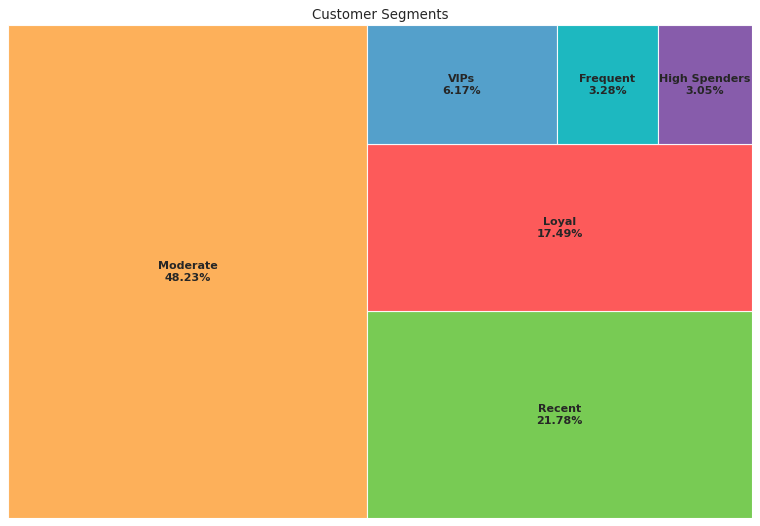

In [44]:
import squarify

sq_labels = df_groupings.apply(lambda x: str(x[0]) + "\n" + str(x[2]) + "%", axis=1)
sizes = df_groupings['count'].values.tolist()
colors = [ palette.get(c) for c in df_groupings['Cluster'].values]

plt.figure(figsize=(12,8), dpi= 80)
squarify.plot( label=sq_labels, sizes=sizes, color=colors, alpha=0.9, text_kwargs={'fontweight':'semibold'})

plt.title('Customer Segments')
plt.axis('off')
plt.show()

## 7 Customer Segmentation Analysis and Recommendations

<font color='#fda848'><b>MODERATE</b></font>

- Moderately frequent buyers that are not necessarily high spenders, and haven't purchased recently. 

Recommendation: 
1. Offer subscription on frequently bought items (whenever applicable)
2. Recommend "Frequently bought together" items
3. Implement customer retention and loyalty programs

<font color='#69c641'><b>RECENT</b></font>


- Less frequent buyers who are low-spenders but made recent purchases.

Recommendations:
1. Identify recently purhcased products and run targeted "similar products" ad recommendations
2. Encourage to purchase more by offering incentives, vouchers, discounts, and bundle deals. 
3. Enhance customer experience and services

<font color='#fd4848'><b>LOYAL</b></font>

- Frequent shoppers who are high spenders, although no recent purchases.

Recommendations:
1. Re-engage by implementing rewards and loyalty programs, and exclusive perks
2. Run targeted ads for trending items and top items sold 
3. Offer subscription on frequently bought items (whenever applicable)

<font color='#4196c6'><b>VIPs</b></font>

- High value, frequent buyers. 

Recommendations:
1. Offer exclusive perks, and vouchers
2. Pamper and enhance shopping experience by offering expedited or free shipping (whenever applicable)

<font color='#04b1b9'><b>FREQUENT</b></font>

- Very frequent buyers. 

Recommendations:
1. Offer subscription on frequently bought items (whenever applicable)
2. Implement customer retention and loyalty programs
3. Offer expedited or free shipping vouchers (whenever applicable)

<font color='#7a4aa2'><b>HIGH SPENDERS</b></font>

- High-spending buyers.

Recommendation: 
1. Implement customer retention and loyalty programs
2. Offer discounts on bulk purchases or reaching certain amount (whenever applicable)
3. Enhance customer experience and services